In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rootdir = 'LBQS1435-0134/STIS/'

In [3]:
fname = rootdir + 'oco703010_x1d.fits'
spec_data = fits.open(fname)

In [4]:
spec_data.info()

Filename: LBQS1435-0134/STIS/oco703010_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     300   ()      
  1  SCI           1 BinTableHDU    157   29R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


In [5]:
spec_data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                38946 / width of table in bytes                        
NAXIS2  =                   29 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   19 / number of fields in each row                   
TTYPE1  = 'SPORDER '           / label for field   1                            
TFORM1  = '1I      '           / data format of field: 2-byte INTEGER           
TTYPE2  = 'NELEM   '           / label for field   2                            
TFORM2  = '1I      '           / data format of field: 2-byte INTEGER           
TTYPE3  = 'WAVELENGTH'      

In [6]:
n_orders = spec_data[1].data.shape[0]
n_pixels = spec_data[1].data[0][2].shape[0]

In [7]:
spec_orders = np.zeros((n_orders, n_pixels, 3))

In [8]:
for i in range(n_orders):
    spec_orders[i,:,0] = spec_data[1].data[n_orders-i-1][2]
    spec_orders[i,:,1] = spec_data[1].data[n_orders-i-1][6]
    spec_orders[i,:,2] = spec_data[1].data[n_orders-i-1][7]

In [9]:
stitch_indices = np.zeros(n_orders-1, dtype=int)

In [10]:
for i in range(n_orders-1):

    wav_order_1 = spec_orders[i,:,0]
    wav_order_2 = spec_orders[i+1,:,0]

    del_wav_arr = wav_order_1-wav_order_2[0]

    idx = list(del_wav_arr).index(max(del_wav_arr[del_wav_arr<0]))

    stitch_indices[i] = idx

    n_rem_order_1 = len(wav_order_1[idx:])

    wav_order_2[0:n_rem_order_1] = wav_order_1[idx:].copy()

    spec_orders[i+1,:,0] = wav_order_2.copy()

In [11]:
wav_dict = {}

In [12]:
for i in range(n_orders-1):
    for j in range(stitch_indices[i]):
        wav_dict[spec_orders[i][j][0]] = []
        

for w in spec_orders[-1,:,0]:
    wav_dict[w] = []

In [13]:
wav_stitch = np.array(list(wav_dict.keys()))
flux_stitch = np.zeros(len(wav_stitch))
err_stitch = np.zeros(len(wav_stitch))

In [14]:
wav_stitch

array([1984.53576852, 1984.56847971, 1984.60119076, ..., 2781.82091985,
       2781.86559307, 2781.91026606])

In [15]:
for i in range(n_orders):
    for j in range(n_pixels):
        wav_dict[spec_orders[i][j][0]].append([spec_orders[i][j][1],spec_orders[i][j][2]])

In [16]:
trim = False

In [17]:
for i in range(len(wav_dict)):
    
    wav = wav_stitch[i]
    
    flux_arr = wav_dict[wav]
    
    if(len(flux_arr) == 2):
        
        
        flux_stitch[i] = 0
        err_stitch[i] = 0
        
        if(trim == True):
        
            if(flux_arr[0][1] < flux_arr[1][1]):
            
                flux_stitch[i] = flux_arr[0][0]
                err_stitch[i] = flux_arr[0][1]
            
            else:
            
                flux_stitch[i] = flux_arr[1][0]
                err_stitch[i] = flux_arr[1][1]
                
        else:
            
            F1 = flux_arr[0][0]
            F2 = flux_arr[1][0]
            
            s1 = flux_arr[0][1]
            s2 = flux_arr[1][1]
            
            w1 = s2**2*(2*F2-F1)/(s1**2*F2 + 4*s2**2*F2 - 3*s2**2*F1)
            w2 = 1-w1

            flux_stitch[i] = w1*F1 + w2*F2
            err_stitch[i] = np.sqrt(w1**2*F1**2 + w2**2*F2**2)

    else:
        flux_stitch[i] = flux_arr[0][0]
        err_stitch[i] = flux_arr[0][1]  

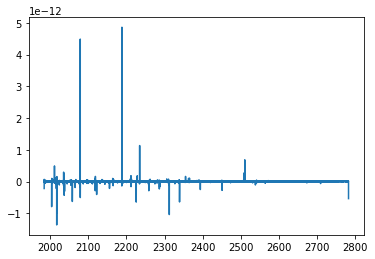

In [18]:
plt.plot(wav_stitch, flux_stitch)

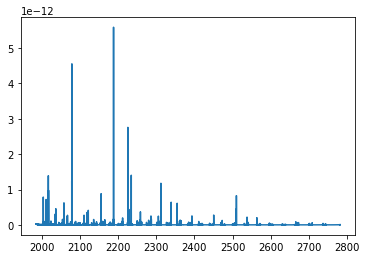

In [19]:
plt.plot(wav_stitch, err_stitch)